# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'traffic.csv', header=None)
df = df[1:].astype('float').T

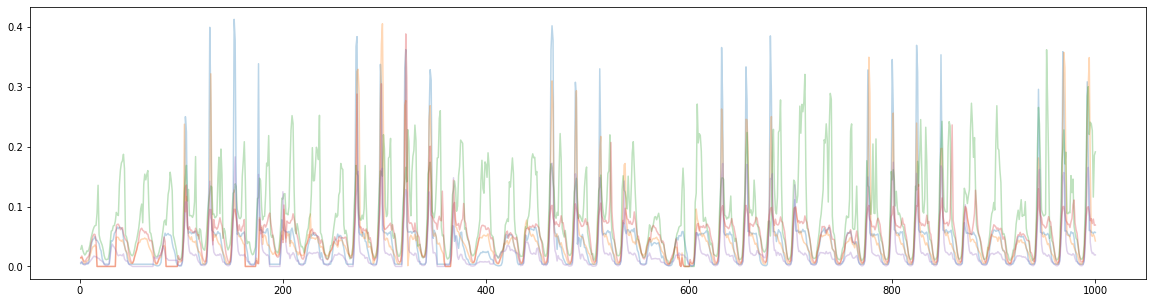

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df.iloc[:5, :1000].T, alpha=.3)
plt.show()

In [5]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

### Special DataLoader for Traffic Data ###

In [6]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.) / (len(x)))

class DataLoaderH(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, horizon, window, pred_step, normalize=2):
        """
        1.Get Data
        2. Normalize 
        3. Split
        """
        self.P = window
        self.h = horizon
        self.pred_step = pred_step
        
        fin = open(file_name)
        self.rawdat = np.loadtxt(fin, delimiter=',')
        self.dat = np.zeros(self.rawdat.shape)

        self.n, self.m = self.dat.shape
        self.normalize = 2
        self.scale = np.ones(self.m)
        self.bias =  np.zeros(self.m)
        self._normalized(normalize)
        self._split(int(train * self.n), int((train + valid) * self.n), self.n)

        self.scale = torch.from_numpy(self.scale).float()
        self.bias = torch.from_numpy(self.bias).float()
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.h, self.m)

        self.scale = self.scale.cuda()
        self.scale = Variable(self.scale)
        self.bias = self.bias.cuda()
        self.bias = Variable(self.bias)

        tmp = tmp[:, -1, :].squeeze()
        self.rse = normal_std(tmp)
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)))

    def _normalized(self, normalize):
        """
        Normalize Data
        0. No Normalization
        1. MinMaxScaler - by one scaler
        2. MinMaxScaler - by each sensor
        3. StandardScaler - by each sensor
        """
        if (normalize == 0):
            self.dat = self.rawdat

        if (normalize == 1):
            # normalized by the maximum value of entire matrix.
            self.dat = self.rawdat / np.max(self.rawdat)
        
        if (normalize == 2):
            # normlized by the maximum value of each row (sensor).
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:, i]))
                self.dat[:, i] = self.rawdat[:, i] / np.max(np.abs(self.rawdat[:, i]))

        if (normalize == 3):
            # normlized by the mean/std value of each row (sensor).
            for i in range(self.m):
                self.scale[i] = np.std(self.rawdat[:, i]) #std
                self.bias[i] = np.mean(self.rawdat[:, i])
                self.dat[:, i] = (self.rawdat[:, i] - self.bias[i]) / self.scale[i]


    def _split(self, train, valid, test):
        """
        Train-Valid-Test Split
        1. Make as Dataset
        2. Make as Loader
        """
        train_set = range(self.P + self.pred_step, train)
        valid_set = range(train, valid)
        test_set = range(valid, self.n)
        self.train = self._batchify(train_set, self.h)
        self.valid = self._batchify(valid_set, self.h)
        self.test = self._batchify(test_set, self.h)

    def _batchify(self, idx_set, horizon):
        n = len(idx_set)
        X = torch.zeros((n, self.P, self.m))
        Y = torch.zeros((n, self.h, self.m))
        for i in range(n):
            end = idx_set[i] - self.pred_step + 1
            start = end - self.P
            X[i, :, :] = torch.from_numpy(self.dat[start:end, :])
            Y[i, :, :] = torch.from_numpy(self.dat[[end+self.pred_step-1], :])
        return [X, Y]

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        """
        get Batch
        """
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]
            Y = targets[excerpt]
            X = X.cuda()
            Y = Y.cuda()
            yield Variable(X), Variable(Y)
            start_idx += batch_size

In [7]:
batch_size = 64
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 200
lr = 1e-4

In [8]:
train_ratio = 0.6
valid_ratio = 0.2
window = 168
horizon = 1
pred_step = 24
normalize = 2

loader = DataLoaderH(data_folder+'traffic.txt', train_ratio, valid_ratio, horizon, window, pred_step, normalize)

# 2. CNN Model (similar architecture w DynamicRouting CapsNet)

In [9]:
result_folder = '../check/darnn/prediction_traffic/'
os.makedirs(result_folder, exist_ok=True)

In [10]:
class DARNN(nn.Module):
    def __init__(self, in_features, out_features):
        super(DARNN, self).__init__()
        
        self.features = in_features
        self.n_layers = 1
        self.hidden=32
        self.dec_hidden=256
        self.time = window
        
        self.softmax = nn.Softmax()
        
        ###Input Attetnion###
        self.input_conv = nn.Conv1d(self.time+self.hidden, 1, kernel_size=1, stride=1)
        
        ###Encoder###
        self.enc_gru = nn.GRU(input_size=self.features, hidden_size=self.hidden, num_layers = self.n_layers, dropout=0.1, batch_first=True)
        
        ###Temporal Attention###
        self.temp_conv = nn.Sequential(
            nn.Conv1d(self.hidden+self.dec_hidden, self.dec_hidden, kernel_size=1, stride=1),
            nn.Tanh(),
            nn.Conv1d(self.dec_hidden, 1, kernel_size=1, stride=1)
        )
        
        ###Decoder###
        self.tilde_fc = nn.Linear(self.hidden+in_features, 1)
        self.dec_gru = nn.GRU(input_size=1, hidden_size=self.dec_hidden, batch_first=True, num_layers=self.n_layers, dropout=0.1)
        
        ###Prediction###
        self.out = nn.Linear(self.dec_hidden+self.hidden, out_features)
        
    def forward(self, x):
        weight = next(self.parameters()).data
        h = weight.new(self.n_layers, x.shape[0], self.hidden).zero_()
        h2 = weight.new(self.n_layers, x.shape[0], self.dec_hidden).zero_()
        
        ###Encoder###
        hiddens_enc =[]
        for t in range(self.time):
            feature = torch.cat([x, h.repeat(self.features, 1, 1).permute(1,2,0)], dim=1)
            input_attn = self.softmax(self.input_conv(feature))
            weighted_input = torch.mul(input_attn.squeeze(1), x[:, t, :])
            
            enc, h = self.enc_gru(weighted_input.unsqueeze(1), h)
            hiddens_enc.append(h.transpose(0, 1))
            
        enc_output = torch.cat(hiddens_enc, dim=1)
        
        ###Decoder###
        #h2 = weight.new(self.n_layers, x.shape[0], self.hidden).zero_()
        for t in range(self.time):
            enc = torch.cat([enc_output.permute(0,2,1), h2.repeat(self.time, 1, 1).permute(1,2,0)], dim=1)
            context = torch.bmm(self.softmax(self.temp_conv(enc)), enc_output).squeeze(1)
            y_tilde = self.tilde_fc(torch.cat([x[:, [t], :], context.unsqueeze(1)], dim=2).squeeze())
            dec, h2 = self.dec_gru(y_tilde.unsqueeze(1), h2)
        
        dec_output = torch.cat([h2.squeeze(0), context], dim=1)
        
        ###Prediction###
        outputs = self.out(dec_output)
        
        return outputs

In [11]:
model = DARNN(in_features= 862,
            out_features=862).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()

In [12]:
model

DARNN(
  (softmax): Softmax(dim=None)
  (input_conv): Conv1d(200, 1, kernel_size=(1,), stride=(1,))
  (enc_gru): GRU(862, 32, batch_first=True, dropout=0.1)
  (temp_conv): Sequential(
    (0): Conv1d(288, 256, kernel_size=(1,), stride=(1,))
    (1): Tanh()
    (2): Conv1d(256, 1, kernel_size=(1,), stride=(1,))
  )
  (tilde_fc): Linear(in_features=894, out_features=1, bias=True)
  (dec_gru): GRU(1, 256, batch_first=True, dropout=0.1)
  (out): Linear(in_features=288, out_features=862, bias=True)
)

# Model Training & Evaluation #

In [13]:
train_loss_list = []
valid_loss_list = []

data = loader
X_train = data.train[0]
Y_train = data.train[1]

X_valid = data.valid[0]
Y_valid = data.valid[1]
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(data.get_batches(X_train, Y_train, 64, False), leave=False):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x).squeeze()
        y = y.squeeze()

        scale = data.scale.expand(outputs.size(0), horizon, data.m).squeeze()
        bias = data.bias.expand(outputs.size(0), horizon, data.m).squeeze()

        loss = torch.sqrt(criterion(outputs*scale+bias, y*scale+bias))
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(data.get_batches(X_valid, Y_valid, 64, False), leave=False):
            x = x.to(device)
            y = y.to(device)
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x).squeeze()
            y = y.squeeze()

            scale = data.scale.expand(outputs.size(0), horizon, data.m).squeeze()
            bias = data.bias.expand(outputs.size(0), horizon, data.m).squeeze()

            loss = torch.sqrt(criterion(outputs*scale+bias, y*scale+bias))
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    """
    if epoch % 20 ==0 :       
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'darnn-pred-traffic-{epoch}.pt')s
    """
    
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss': valid_loss_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'darnn-pred-traffic-best.pt')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 0/200 | trn_loss: 0.0539 | val_loss: 0.0506


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 1/200 | trn_loss: 0.0485 | val_loss: 0.0505


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 2/200 | trn_loss: 0.0485 | val_loss: 0.0505


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 3/200 | trn_loss: 0.0484 | val_loss: 0.0505


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 4/200 | trn_loss: 0.0484 | val_loss: 0.0505


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 5/200 | trn_loss: 0.0484 | val_loss: 0.0505


0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

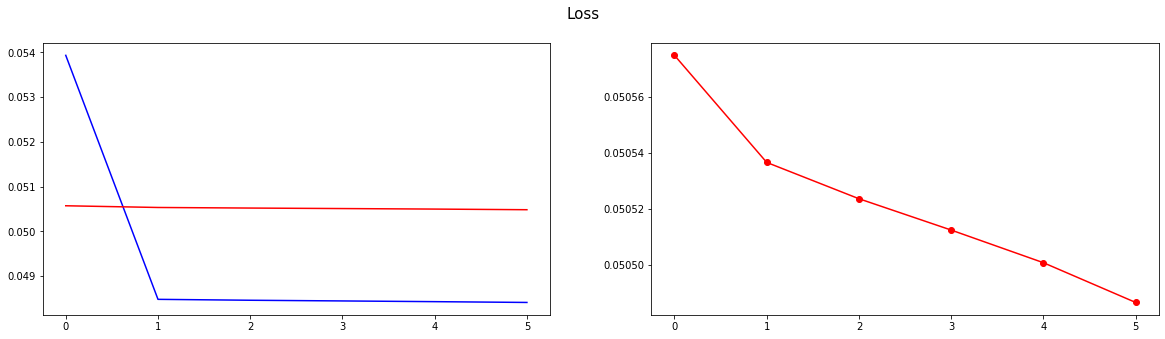

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'darnn_loss.png')

In [15]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'darnn_loss.csv', index=0)

### Performance Evaluation

In [16]:
checkpoint = torch.load(result_folder + 'darnn-pred-traffic-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'])

5 0.05048658156936819


In [22]:
model = model.eval()
test_loss = []
answers = []
predictions = []

X_test = data.test[0]
Y_test = data.test[1]

with torch.no_grad():
    for (x, y) in tqdm(data.get_batches(X_test, Y_test, 64, False), leave=False):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x).squeeze()
        y = y.squeeze()

        scale = data.scale.expand(outputs.size(0), horizon, data.m).squeeze()
        bias = data.bias.expand(outputs.size(0), horizon, data.m).squeeze()

        loss = torch.sqrt(criterion(outputs*scale+bias, y*scale+bias))
        
        answers.extend((y*scale+bias).squeeze().detach().cpu().numpy())
        predictions.extend((outputs*scale+bias).squeeze().detach().cpu().numpy())
        test_loss.append(loss.item())  
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

0it [00:00, ?it/s]

test loss: 0.052572774887084964


In [23]:
result_ans = pd.DataFrame(answers)
result_pred = pd.DataFrame(predictions)

result_ans.to_csv(result_folder + 'result_ans.csv')
result_pred.to_csv(result_folder + 'result_pred.csv')

In [24]:
result_pred.shape

(3509, 862)

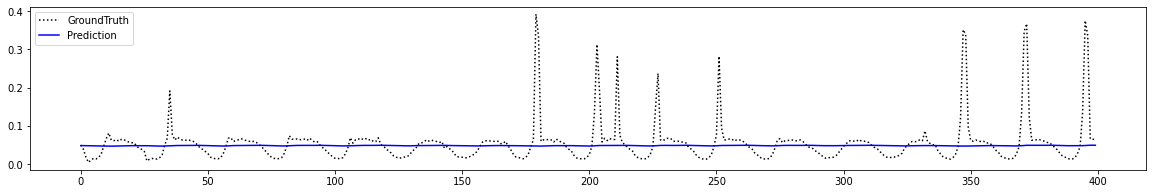

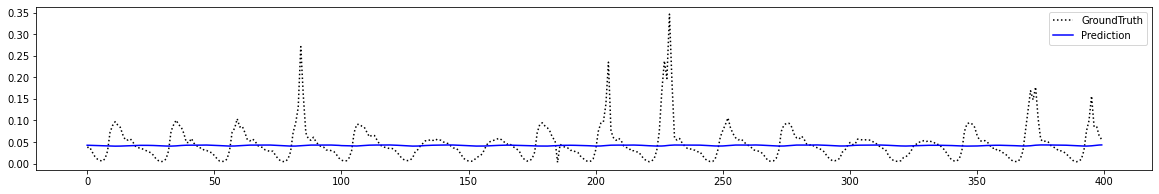

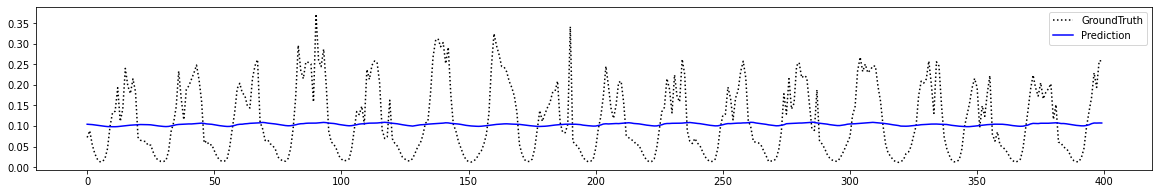

In [25]:
for i in range(3):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[:400, i], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[:400, i], c='blue', label='Prediction')
    plt.legend()
    plt.savefig(result_folder + f'sample{i}_predresult.png')